#Monitoramento de emissão de gases poluentes

Bruno Nogueira Burian RM552863


Lucca Augusto Matteoni RM98146


Luccas dos Anjos Correria da Silva RM552890

In [10]:
!pip install pandas numpy scikit-learn matplotlib xgboost

###Importação de bibliotecas

In [34]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###Importação do Dataset

In [37]:
df = pd.read_csv("Methane_final.csv", sep=",", header=0)

In [26]:
# Visualizar
df.head()

,Unnamed: 0,region,country,emissions,type,segment,reason,baseYear,notes
0,0,Africa,Algeria,257.611206,Agriculture,Total,All,2019-2021,Average based on United Nations Framework Conv...
1,1,Africa,Algeria,0.052000,Energy,Bioenergy,All,2022,Estimates from end-uses are for 2020 or 2021 (...
2,2,Africa,Algeria,130.798996,Energy,Gas pipelines and LNG facilities,Fugitive,2022,Not available
3,3,Africa,Algeria,69.741898,Energy,Gas pipelines and LNG facilities,Vented,2022,Not available
4,4,Africa,Algeria,213.987000,Energy,Onshore gas,Fugitive,2022,Not available


##Modelo de Previsão

In [38]:
# Renomear a coluna 'Unnamed: 0' para 'Id'
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# Remover as colunas 'notes' e 'baseYear'
df.drop(columns=['notes', 'baseYear'], inplace=True)

In [28]:
# Visualizar o resultado
print(df.head())

   Id  region  country   emissions         type  \
0   0  Africa  Algeria  257.611206  Agriculture   
1   1  Africa  Algeria    0.052000       Energy   
2   2  Africa  Algeria  130.798996       Energy   
3   3  Africa  Algeria   69.741898       Energy   
4   4  Africa  Algeria  213.987000       Energy   

                            segment    reason  
0                             Total       All  
1                         Bioenergy       All  
2  Gas pipelines and LNG facilities  Fugitive  
3  Gas pipelines and LNG facilities    Vented  
4                       Onshore gas  Fugitive  


In [29]:
# Lidar com dados categóricos usando One-Hot Encoding
X = pd.get_dummies(df.drop(columns=['emissions', 'Id']), drop_first=True)

# Variável-alvo
y = df['emissions']

In [30]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Treinar e avaliar modelos
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = (rmse, mae, r2)
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

Decision Tree - RMSE: 4437.46, MAE: 837.82, R²: 0.71
XGBoost - RMSE: 4685.46, MAE: 850.50, R²: 0.68


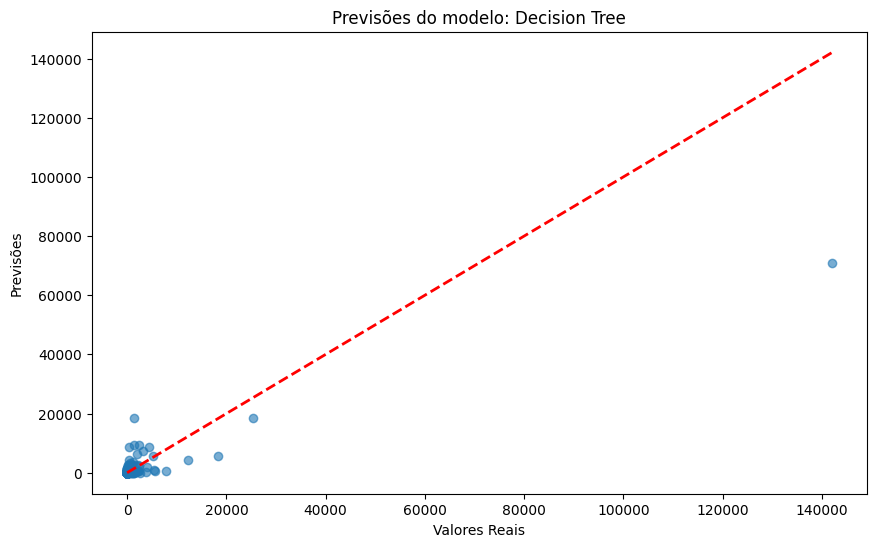

['melhor_modelo.pkl']

In [32]:
# Visualizar os resultados do melhor modelo
best_model_name = min(results, key=lambda x: results[x][0])  # Modelo com menor RMSE
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title(f"Previsões do modelo: {best_model_name}")
plt.show()

# Salvar o modelo escolhido
joblib.dump(best_model, "melhor_modelo.pkl")

## Modelo de Classificação

In [39]:
df = pd.read_csv("Methane_final.csv", sep=",", header=0)

In [40]:
# Renomear a coluna 'Unnamed: 0' para 'Id'
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# Remover as colunas 'notes' e 'baseYear'
df.drop(columns=['notes', 'baseYear'], inplace=True)

In [41]:
# 1. Criar as classes para classificação
df['emission_class'] = pd.qcut(df['emissions'], q=3, labels=['Baixa', 'Média', 'Alta'])

In [42]:
# 2. Separar variáveis preditoras (X) e variável-alvo (y)
X = pd.get_dummies(df.drop(columns=['emissions', 'Id', 'emission_class']), drop_first=True)
y = df['emission_class']

In [43]:
# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# 4. Treinar modelo de classificação (Random Forest como exemplo)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
# 5. Fazer previsões
y_pred = clf.predict(X_test)

Relatório de classificação:

              precision    recall  f1-score   support

        Alta       0.61      0.70      0.65       117
       Baixa       0.62      0.59      0.60        93
       Média       0.44      0.38      0.41       100

    accuracy                           0.56       310
   macro avg       0.56      0.56      0.55       310
weighted avg       0.56      0.56      0.56       310



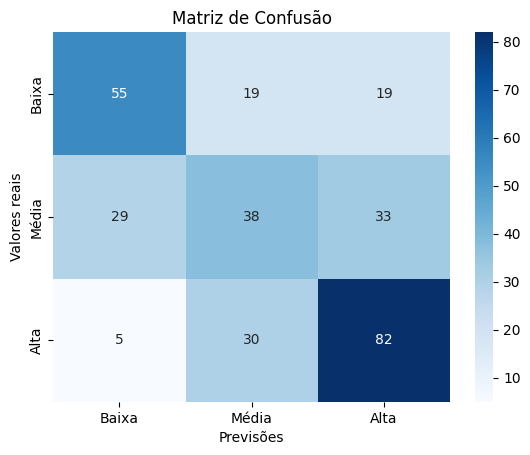

In [46]:
# 6. Avaliar o modelo
print("Relatório de classificação:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred, labels=['Baixa', 'Média', 'Alta'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa', 'Média', 'Alta'], yticklabels=['Baixa', 'Média', 'Alta'])
plt.xlabel('Previsões')
plt.ylabel('Valores reais')
plt.title('Matriz de Confusão')
plt.show()